# Project 2<br>Predict IMDb Rating

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
# Basic EDA, cleaning, and visualization modules

from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import requests
# Webscraping 

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
import scipy.stats as stats
# Modeling

from directors_to_list import directors_list, remove_paren
from imdb_big_scrape import get_movie_links
from getting_info import get_movie_data
# Functions I made in corresponding .py files

import pickle
%load_ext autoreload
%autoreload 2

## Step 1: Collect links using the 'get_movie_links' function
This function gathers data from IMDb using BeautifulSoup. Specifically, the function focuses on movies between 2018 and 2020 to be accurate prediting in the near future. The input to the function is how many pages is desired to scrape. Each page holds 100 movies. The function is liable to take some time, so I like the option to scrape less pages if desired.

In [5]:
movie_links = get_movie_links(20)
# Collect movie links
# 5  -->  500 links
# 10 --> 1000 links
# 20 --> 2000 links
# 40 --> 4000 links

## Step 2: Use the 'get_movie_data' function to collect desired data
This function also uses BeautifulSoup and takes the links collected using the get_movie_links function to return a list full of dictionaries holding information for each link passed into the function. After collecting the data, it's very easy to pass this into a Pandas DataFrame.

In [10]:
count = 0
movie_data_list = []
for link in movie_links:
    movie_data_list.append(get_movie_data(link))
    count += 1
    if count % 50 == 0:
        with open('IMDb_top_2000s.pickle', 'wb') as to_write:
            pickle.dump(movie_data_list, to_write)
# Create list with all movies from movie links

In [184]:
df2 = pd.DataFrame(movie_data_list)

In [237]:
movie_page_info = pd.DataFrame(movie_data_list)
# Turn data into a DataFrame for easy analysis

In [2]:
movies_8000 = pd.DataFrame(pd.read_pickle('IMDb_8000.pickle'))
df1 = pd.DataFrame(pd.read_pickle('IMDb_top_movies.pickle'))
df2 = pd.DataFrame(pd.read_pickle('IMDb_top_2000s.pickle'))
# Reloaded pickled data after I reset the notebook
# IMDB_8000 contains 8000 movies between 2015 and 2020
# IMDb_top_movies supplements the data with top rated movies between 2010 and 2020
# IMDB_top_2000s supplements more top movies in the 2000s

In [3]:
movies_8070 = pd.concat([movies_8000,df1,df2])

## Step 3: Dive into the data to further understand relationships

In [144]:
movies_df = movies_8070.copy()
movies_df.drop_duplicates(subset=['movie title'],inplace=True)
# Copy the original dataframe to mess with the data more freely

In [145]:
movies_df.set_index('movie title',inplace=True)
# Reset the index to be the Movie Title

In [146]:
movies_df_drop = movies_df.dropna(subset=['budget'])
# Drop movies without budget data

In [147]:
movies_df_drop.info()
# See what we're working with

<class 'pandas.core.frame.DataFrame'>
Index: 2655 entries, Mulan to Cinderella Man
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb rating           2495 non-null   float64
 1   imdb raters           2495 non-null   float64
 2   mpaa                  1581 non-null   object 
 3   genres                2654 non-null   object 
 4   director              2652 non-null   object 
 5   writer                2651 non-null   object 
 6   stars                 2594 non-null   object 
 7   country               2655 non-null   object 
 8   language              2655 non-null   object 
 9   release date          2464 non-null   object 
 10  budget                2655 non-null   float64
 11  opening weekend       931 non-null    float64
 12  gross usa             957 non-null    float64
 13  cumulative worldwide  1118 non-null   float64
 14  production companies  2480 non-null   object 
 15  runtime (min

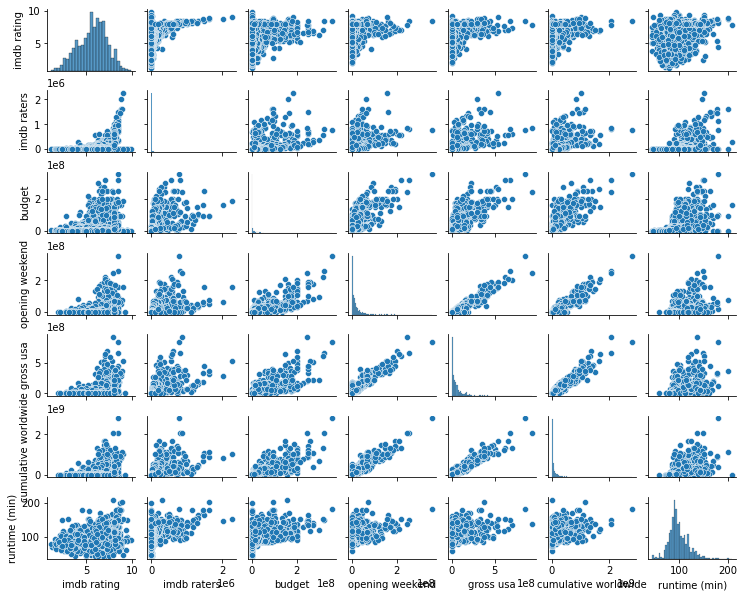

In [148]:
sns.pairplot(movies_df_drop, height=1.2, aspect=1.25);
# Visualize some relationships

## Step 4: Clean up data and add features

Drop rows with no rating, no release date, and no runtime<br>
Fill rows with empy MPAA with the filler 'N/A'

In [149]:
movies_df_drop['mpaa'].fillna('N/A', inplace=True)
# I don't want to lose titles with no MPAA, so let's fill in missing values with "N/A"

In [150]:
movie_drop2 = movies_df_drop[movies_df_drop['imdb rating'].notna()]
# Drop movies without a rating

In [151]:
movie_drop2 = movie_drop2[movie_drop2['imdb raters'] >= 1000]
# Remove movies with less than 1,000 raters for better validity in ratings

In [152]:
movie_drop2 = movie_drop2[movie_drop2['budget'] >= 1000]
# Remove movies with less than a $1,000 budget to focus model

In [153]:
movie_drop2 = movie_drop2[movie_drop2['runtime (min)'].notna()]
# Removes movies without Runtime data

### Feature: Runtime
Test out a basic component of the new DataFrame.<br>
Target: IMDb Rating

In [154]:
X, y = movie_drop2[['runtime (min)']], movie_drop2['imdb rating']

In [155]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.26865461610593155

Turned out small, but I think we can do better.<br>
Let's attempt to turn MPAA into dummy variables

### Feature: MPAA Rating

In [156]:
mpaa_df = pd.get_dummies(movie_drop2['mpaa'])
# Get dummy variables for MPAA ratings

In [157]:
df_added_mpaa_dummies = pd.concat([movie_drop2,mpaa_df], axis=1)
# Add them to the rest of the data

In [158]:
X, y = df_added_mpaa_dummies[['runtime (min)','budget','G','N/A','Not Rated','PG','PG-13','R','TV-MA','Unrated']], df_added_mpaa_dummies['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# Let's add the MPAA dummy variables and budget to our model

0.31809837437427413

The result was only a little bit better with the MPAA data. <br>
Let's try to add in genre dummy variables


### Feature: Genre

In [159]:
df_genres_added = pd.Series(df_added_mpaa_dummies['genres'])
df_genres_added = pd.get_dummies(df_genres_added.apply(pd.Series).stack()).sum(level=0)
# Turns genres into dummy variables

In [160]:
df_genres_mpaa = pd.concat([df_added_mpaa_dummies, df_genres_added], axis=1)

In [161]:
df_genres_mpaa.drop(labels=['opening weekend','gross usa','cumulative worldwide'],axis=1,inplace=True)
# Let's drop the columns we're not using to make it easier to view

In [162]:
X, y = df_genres_mpaa[['runtime (min)','budget','G','N/A','Not Rated','PG','PG-13','R','TV-MA','Unrated','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western']], df_genres_mpaa['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.3996964906277858

Simple initial tests worked fairly well to get an MVP.<br>
Now I'd like to try and sort out Director, Writer, and Stars columns to create<br>
some more intricate measures of success

### Feature: Director

In [167]:
movie_drop2[movie_drop2['director']==''].index.tolist()

['Spider-Man: Into the Spider-Verse',
 'Moana',
 'Zootopia',
 'Despicable Me 3',
 'Animal Crackers',
 'The Lego Ninjago Movie',
 'The Wild Life',
 'The Heyday of the Insensitive Bastards',
 'Dude Bro Party Massacre III',
 'Sin City',
 'Monsters, Inc.']

It seems like there are a few movings missing their director information. I'll just add in this information manually since it's only a few.

In [169]:
empty_dir = movie_drop2[movie_drop2['director']==''].index.values.tolist()
# Putting those movies into a list

In [168]:
dir_fill = [
    'Peter Ramsey, Bob Persichetti, Rodney Rothman',
    'Ron Clements, John Musker',
    'Byron Howard, Rich Moore',
    'Pierre Coffin, Chris Renaud',
    'Scott Sava, Tony Bancroft',
    'Charlie Bean, Bob Logan, Paul Fisher',
    'Vincent Kesteloot, Ben Stassen',
    'Mark Columbus, Shadae Lamar Smith',
    'Michael Rousselet, Jon Salmon',
    'Frank Miller, Quentin Tarantino, Robert Rodriguez',
    'Dan Scanlon, Saschka Unseld'
    ]
# Got the directors corresponding to the movies

In [170]:
for num, movie in enumerate(empty_dir):
    movie_drop2['director'][movie] = dir_fill[num]
# Run through the empty directors and fill with added info

In [171]:
movie_drop2['director'] = movie_drop2['director'].apply(lambda x: directors_list(x))
# Turns directors into a list to fix some inconsistencies

In [172]:
movie_drop2['director'] = movie_drop2['director'].apply(lambda x: remove_paren(x))
# Remove parentheses in director columns

In [173]:
df_dir_exploded = movie_drop2.explode('director')
# Explode out directors to report on their relevance

In [174]:
dir_10 = df_dir_exploded['director'].value_counts()[:10].index.tolist()

In [175]:
def top_directors(directors):
    dir_list = []
    for director in directors:
        if director in dir_10:
            dir_list.append(director)
    return dir_list
# Create a function to select top directors and create new columns
# This will let us create dummy variables just for top directors

In [176]:
movie_drop2['top directors'] = movie_drop2['director'].apply(lambda x: top_directors(x))

In [177]:
dir_df = pd.get_dummies(movie_drop2['top directors'].apply(pd.Series).stack()).sum(level=0)

In [178]:
df_dir_model = pd.concat([df_genres_mpaa, dir_df], axis=1)

In [179]:
df_dir_model.drop(labels=['imdb raters','genres','director','writer','stars','country','language','release date','production companies'],axis=1,inplace=True)
# Let's take out the columns we're not using

In [180]:
df_dir_model.replace(np.nan,0,inplace=True)
# Replace all of the NaN values with 0s to turn it into a proper binary dataset

In [181]:
X, y = df_dir_model.iloc[:,2:], df_dir_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# So we moved up 0.02 points again, which isn't nothing. Let's try the same concept for writers

0.4265440951408025

So this model was only a small improvement, but let's keep adding features

### Feature: Writer

In [182]:
writ_df = pd.get_dummies(movie_drop2['writer'])
# The writer column isn't in list form, so we can just get dummy variables

In [183]:
writ_10 = movie_drop2.writer.value_counts()[:10].index.tolist()
# Let's only single out the top 10 most frequently occuring writers

In [184]:
df_writ_model = pd.concat([df_dir_model,writ_df[writ_10]],axis=1)

In [185]:
X, y = df_writ_model.iloc[:,2:], df_writ_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.4396191171986654

So we moved up a little over 0.01 points, which isn't nothing, either. Let's try the same concept for stars

### Feature: Stars

In [186]:
stars_exploded = movie_drop2.explode('stars')
# Let's do something similar to director

In [187]:
stars_20 = stars_exploded['stars'].value_counts()[:20].index.tolist()
# Let's take the top 20 stars instead of just 10

In [188]:
def top_stars(stars):
    star_list = []
    for star in stars:
        if star in stars_20:
            star_list.append(star)
    return star_list
# Create a function to select top stars and create new columns
# This will let us create dummy variables just for top stars

In [189]:
movie_drop2['top stars'] = movie_drop2['stars'].apply(lambda x: top_stars(x))

In [190]:
stars_df = pd.get_dummies(movie_drop2['top stars'].apply(pd.Series).stack()).sum(level=0)

In [191]:
star_model = pd.concat([df_writ_model, stars_df[stars_20]], axis=1)

In [192]:
star_model.replace(np.nan,0,inplace=True)

In [193]:
X, y = star_model.iloc[:,2:], star_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.4494299603829781

Once again, this is the smallest improvement in our model. What else can we try?<br>
Let's try this same concept for Production Companies and then move on to a new approach.

### Feature: Production Company

In [194]:
prod_exploded = movie_drop2.explode('production companies')
# You know the drill

In [195]:
prod_15 = prod_exploded['production companies'].value_counts()[:15].index.tolist()

In [196]:
movie_drop2.loc[movie_drop2['production companies'].isnull(),'production companies'] = movie_drop2.loc[movie_drop2['production companies'].isnull(),'production companies'].apply(lambda x: [])

In [197]:
def top_prod(comp):
    comp_list = []
    for co in comp:
        if co in prod_15:
            comp_list.append(co)
    return comp_list

In [198]:
movie_drop2['top prod co.'] = movie_drop2['production companies'].apply(lambda x: top_prod(x))

In [199]:
prod_df = pd.get_dummies(movie_drop2['top prod co.'].apply(pd.Series).stack()).sum(level=0)

In [200]:
prod_model = pd.concat([star_model, prod_df[prod_15]], axis=1)

In [201]:
prod_model.replace(np.nan,0,inplace=True)

In [202]:
X, y = prod_model.iloc[:,2:], prod_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.4597743153502285

Once again, it's a very small increase.<br>
This was our last categorical column. I think it's worth trying the release month as a feature.

### Feature: Release Month

In [203]:
empty_date = movie_drop2[movie_drop2['release date'].isnull()].index.tolist()
# I noticed some movies without release dates
# Time to manually enter values

In [204]:
empty_date

['The Crash',
 'Burn Your Maps',
 '2020',
 'Cyborg X',
 'The Capture',
 'Bleed',
 'Bad Hero']

In [205]:
dates_fill = [
    pd.to_datetime('20170113', format='%Y%m%d'),
    pd.to_datetime('20160909', format='%Y%m%d'),
    pd.to_datetime('20170902', format='%Y%m%d'),
    pd.to_datetime('20160512', format='%Y%m%d'),
    pd.to_datetime('20171116', format='%Y%m%d'),
    pd.to_datetime('20160325', format='%Y%m%d'),
    pd.to_datetime('20101215', format='%Y%m%d')
    ]
# Got the release dates corresponding to the movies

In [206]:
for num, movie in enumerate(empty_date):
    movie_drop2['release date'][movie] = dates_fill[num]
# Run through the empty dates and fill with added info

In [207]:
movie_drop2['month'] = movie_drop2['release date'].apply(lambda x: x.strftime("%b"))
# Create new month column and fill in with month name

In [208]:
month_df = pd.get_dummies(movie_drop2['month'])
# Get dummies for the months

In [209]:
month_model = pd.concat([prod_model,month_df], axis=1)

In [210]:
X, y = month_model.iloc[:,2:], month_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.4656792283769393

Once again, only slightly better than previous models.<br>
I'd like to add the years since release. I'm not entirely sure if it will correlate to IMDb rating, but it's worth a shot.

### Feature: Years since release

In [211]:
date = pd.to_datetime(datetime.now().date())

In [212]:
movie_drop2['years since release'] = movie_drop2['release date'].apply(lambda x: (((date-pd.to_datetime(x))).days/ 365.25))

In [213]:
month_model['years since release'] = movie_drop2['years since release']

In [214]:
X, y = month_model.iloc[:,2:], month_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# A little bit of a bump!

0.47888093761499584

## Step 5: Train / Validation / Test
Now that I've added all of the features I think are necessary, let's do some more intricate testing.

In [215]:
X, y = month_model.iloc[:,2:], month_model['imdb rating']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [216]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=20)

In [217]:
# Let's first test Linear Regression vs Polynomial Features
lr = LinearRegression()

poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lr_poly = LinearRegression()

In [218]:
lr.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lr.score(X_val, y_val):.3f}')

lr_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lr_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.376
Degree 2 polynomial regression val R^2: 0.176


The Degree 2 polynomial regression does not seem as good as Linear Regression; however, let's do some more rigorous testing on our basic Linear Regression model and try out a Ridge model

In [219]:
# Let's reset the data for the next tests
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X, y = np.array(X), np.array(y)
lr = LinearRegression()

In [220]:
# Here we'll validate our Linear model vs. the Ridge model
kf = KFold(n_splits=5, shuffle=True, random_state = 61)
cv_lr_r2s, cv_lr_reg_r2s = [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #Linear Regression
    lr = LinearRegression()
    lr_reg = Ridge(alpha=1)

    lr.fit(X_train, y_train)
    cv_lr_r2s.append(lr.score(X_val, y_val))
    
    #Ridge
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lr_reg.fit(X_train_scaled, y_train)
    cv_lr_reg_r2s.append(lr_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lr_r2s)
print('Ridge scores: ', cv_lr_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lr_r2s):.3f} +- {np.std(cv_lr_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lr_reg_r2s):.3f} +- {np.std(cv_lr_reg_r2s):.3f}')

Simple regression scores:  [0.3307282172171019, 0.38025933557753466, 0.3346427388866321, 0.3084572785814289, 0.15123650369275876]
Ridge scores:  [0.33147720109839207, 0.38076228553954383, 0.3351004130661862, 0.30896001621241276, 0.15241242467154448] 

Simple mean cv r^2: 0.301 +- 0.078
Ridge mean cv r^2: 0.302 +- 0.078


It looks like the ridge model is performing slightly better than the simple Linear Regression model<br>
Let's investigate the data and model a bit more

In [221]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Rescale the data for more Ridge testing

In [222]:
lr_reg.fit(X_train_scaled, y_train)
cv_lr_reg_r2s.append(lr_reg.score(X_val_scaled, y_val))
# The code for our Ridge model

In [223]:
test_set_pred = lr_reg.predict(X_test_scaled)
# Set our predicted values to a variable

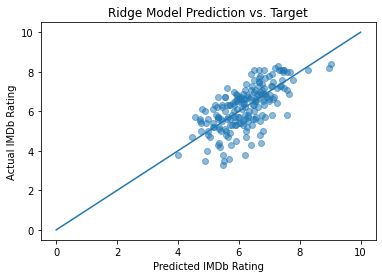

In [224]:
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.title('Ridge Model Prediction vs. Target')
plt.xlabel('Predicted IMDb Rating')
plt.ylabel('Actual IMDb Rating');
# The plot looks fairly decent

In [225]:
print(f'Ridge r2: {r2_score(y_test, test_set_pred)}')
# Also, this r2 score doesn't look too bad either

Ridge r2: 0.44272863089708847


In [226]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

print(f'MAE: {mae(y_test, test_set_pred)}')
# And a MAE of 0.67 isn't the worst

MAE: 0.6729749494964902


In [227]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

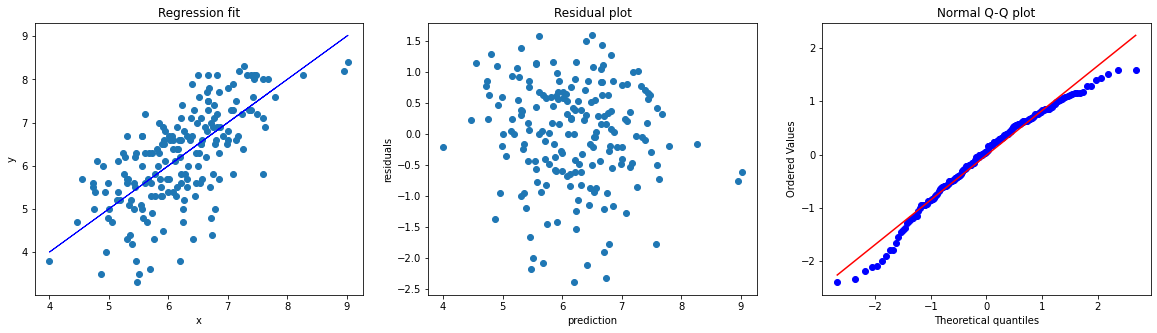

In [228]:
diagnostic_plot(test_set_pred, y_test)
# The head and tails of the Q-Q plot seem to tell a story about our data.

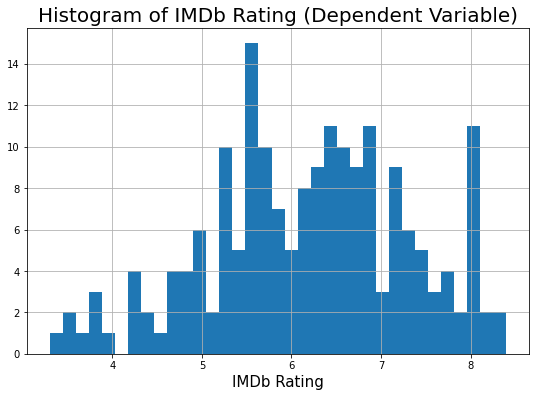

In [240]:
y_test.hist(bins=35,figsize=(9,6))
plt.title('Histogram of IMDb Rating (Dependent Variable)',fontsize=20)
plt.xlabel('IMDb Rating',fontsize=15);
# The histogram shows that our data is concentrated, but I don't think it's worth predicting for lower IMDb scores

## Step 6: Honing in on the important features<br>
Now that we have a model that is decent, let's run some other operations to remove unimportant features and emphasize the most important features.

## Extras: My exploration into leakage

I thought it was a good idea to include the director's mean IMDb average, but quickly learned the defintion of leakage. Let's take a look at what happened.

In [235]:
leakage_model = month_model.copy()
# Let's create a new model to highlight the leakage error I explored in my project.

In [230]:
df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False)[:-100:-1]
print('Min: {}'.format(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False).min()))
print('Max: {}'.format(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False).max()))

# Look at each director's mean rating

Min: 1.3
Max: 9.4


Now I must figure out how to use these mean ratings to organize the directors and include it in the model

In [231]:
mean_dir_rating = pd.DataFrame(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False))
# Group the directors and sort by the mean of their ratings

In [234]:
def dir_rating_column(dir_list):
    for director in dir_list:
        rating = 0
        if mean_dir_rating.loc[director]["imdb rating"] > rating:
            rating = mean_dir_rating.loc[director]["imdb rating"]
        return rating
# Create a function to make this new column
# I decided to just use the mean rating rather than bins

In [236]:
leakage_model['mean director rating'] = movie_drop2['director'].apply(lambda x:dir_rating_column(x))
# Utilize that function

In [238]:
X, y = leakage_model.iloc[:,2:], leakage_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# Look at that score!

0.9196321391082555

I thought I had it all figured out, but after speaking with a TA and a teacher, it was obvious that mean target was leaking into my model, so I had to change this concept and that's when I redirected my concept of treating directors, writers, stars, and production companies.